https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2023/02-experiment-tracking/homework.md

The goal of this homework is to get familiar with tools like MLflow for experiment tracking and model management

In [1]:
from mlflow.tracking import MlflowClient

# Q1. Install the package

run the command mlflow --version and check the output.

What's the version that you have?

In [2]:
!mlflow --version

mlflow, version 2.3.2


Answer: __2.3.2__ version of mlflow

# Q2. Download and preprocess the data

We'll use the Green Taxi Trip Records dataset to predict the amount of tips for each trip.

Download the data for January, February and March 2022 in parquet format from [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

Use the script `preprocess_data.py` located in the folder homework to preprocess the data.

The script will:

* load the data from the folder `<TAXI_DATA_FOLDER>` (the folder where you have downloaded the data),
* fit a `DictVectorizer` on the training set (January 2022 data),
* save the preprocessed datasets and the `DictVectorizer` to disk.

Your task is to download the datasets and then execute this command:

`python preprocess_data.py --raw_data_path <TAXI_DATA_FOLDER> --dest_path ./output`

Tip: go to `02-experiment-tracking/homework/` folder before executing the command and change the value of <TAXI_DATA_FOLDER> to the location where you saved the data.

So what's the size of the saved DictVectorizer file?

In [3]:
!python homework/preprocess_data.py --raw_data_path ../../data --dest_path ./output

In [4]:
ls -lah ./output

total 7.0M
drwxrwxrwx 1 wsl wsl 4.0K Jun  1 23:04 ./
drwxrwxrwx 1 wsl wsl 4.0K Jun  1 23:04 ../
-rwxrwxrwx 1 wsl wsl 151K Jun  1 23:04 dv.pkl*
-rwxrwxrwx 1 wsl wsl 2.6M Jun  1 23:04 test.pkl*
-rwxrwxrwx 1 wsl wsl 2.1M Jun  1 23:04 train.pkl*
-rwxrwxrwx 1 wsl wsl 2.3M Jun  1 23:04 val.pkl*


Answer: __154 kB__ size of the saved DictVectorizer file

# Q3. Train a model with autolog

We will train a `RandomForestRegressor` (from Scikit-Learn) on the taxi dataset.

We have prepared the training script `train.py` for this exercise, which can be also found in the folder `homework`.

The script will:

* load the datasets produced by the previous step,
* train the model on the training set,
* calculate the RMSE score on the validation set.

Your task is to modify the script to enable autologging with MLflow, execute the script and then launch the MLflow UI to check that the experiment run was properly tracked.

Tip 1: don't forget to wrap the training code with a `with mlflow.start_run():` statement as we showed in the videos.

Tip 2: don't modify the hyperparameters of the model to make sure that the training will finish quickly.

What is the value of the `max_depth` parameter:

In [5]:
# added strings to train.py
#mlflow.sklearn.autolog()
#with mlflow.start_run():

In [6]:
!python homework/train.py 

2023/06/01 23:06:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/wsl/miniconda3/envs/mlops/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [7]:
client = MlflowClient()

In [8]:
client.search_runs(experiment_ids='0')[0].data.params['max_depth']

'10'

Answer: __10__ (max_depth parameter)

## Launch the tracking server locally for MLflow

Now we want to manage the entire lifecycle of our ML model. In this step, you'll need to launch a tracking server. This way we will also have access to the model registry.

In case of MLflow, you need to:

* launch the tracking server on your local machine,
* select a SQLite db for the backend store and a folder called artifacts for the artifacts store.

You should keep the tracking server running to work on the next three exercises that use the server.

### launch a tracking server

`mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts`

# Q4. Tune model hyperparameters

Now let's try to reduce the validation error by tuning the hyperparameters of the `RandomForestRegressor` using `optuna`. We have prepared the script `hpo.py` for this exercise.

Your task is to modify the script `hpo.py` and make sure that the validation RMSE is logged to the tracking server for each run of the hyperparameter optimization (you will need to add a few lines of code to the `objective` function) and run the script without passing any parameters.

After that, open UI and explore the runs from the experiment called `random-forest-hyperopt` to answer the question below.

Note: Don't use autologging for this exercise.

The idea is to just log the information that you need to answer the question below, including:

* the list of hyperparameters that are passed to the `objective` function during the optimization,
* the RMSE obtained on the validation set (February 2022 data).

What's the best validation RMSE that you got?

In [9]:
# added strings to hpo.py
# with mlflow.start_run():
#    mlflow.log_params(params)
#    mlflow.log_metric('rmse', rmse)

In [10]:
!python homework/hpo.py

2023/06/01 23:07:05 INFO mlflow.tracking.fluent: Experiment with name 'random-forest-hyperopt' does not exist. Creating a new experiment.
[I 2023-06-01 23:07:06,274] A new study created in memory with name: no-name-03fe5af5-c97b-4d74-b84c-653b0a82bbea
[I 2023-06-01 23:07:10,882] Trial 0 finished with value: 2.451379690825458 and parameters: {'n_estimators': 25, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 2.451379690825458.
[I 2023-06-01 23:07:11,867] Trial 1 finished with value: 2.4667366020368333 and parameters: {'n_estimators': 16, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 2.451379690825458.
[I 2023-06-01 23:07:15,616] Trial 2 finished with value: 2.449827329704216 and parameters: {'n_estimators': 34, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 2.449827329704216.
[I 2023-06-01 23:07:17,217] Trial 3 finished with value: 2.460983516558473 a

In [11]:
MLFLOW_TRACKING_URI = 'sqlite:///mlflow.db'
client = MlflowClient(MLFLOW_TRACKING_URI)

In [12]:
runs = client.search_runs(experiment_ids=1,
                         max_results=5,
                         order_by=['metrics.rmse ASC'])

for run in runs:
    print(f"run name: {run.info.run_name}, score: {run.data.metrics['rmse']}")

run name: trusting-flea-861, score: 2.449827329704216
run name: abrasive-snipe-511, score: 2.451379690825458
run name: awesome-owl-262, score: 2.4516421799356767
run name: capable-auk-441, score: 2.453877262701052
run name: merciful-pig-895, score: 2.455971238567075


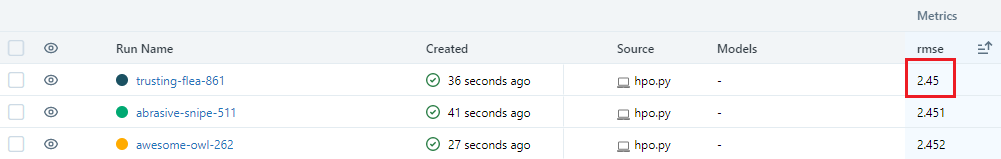

Answer: __2.45__ best RMSE with hyperopt

# Q5. Promote the best model to the model registry

The results from the hyperparameter optimization are quite good. So, we can assume that we are ready to test some of these models in production. In this exercise, you'll promote the best model to the model registry. We have prepared a script called `register_model.py`, which will check the results from the previous step and select the top 5 runs. After that, it will calculate the RMSE of those models on the test set (March 2022 data) and save the results to a new experiment called `random-forest-best-models`.

Your task is to update the script `register_model.py` so that it selects the model with the lowest RMSE on the test set and registers it to the model registry.

Tips for MLflow:

* you can use the method `search_runs` from the `MlflowClient` to get the model with the lowest RMSE,
* to register the model you can use the method `mlflow.register_model` and you will need to pass the right `model_uri` in the form of a string that looks like this: `"runs:/<RUN_ID>/model"`, and the name of the model (make sure to choose a good one!).

What is the test RMSE of the best model?

In [13]:
!python homework/register_model.py

2023/06/01 23:09:11 INFO mlflow.tracking.fluent: Experiment with name 'random-forest-best-models' does not exist. Creating a new experiment.
2023/06/01 23:09:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/wsl/miniconda3/envs/mlops/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
Successfully registered model 'best_model_RF'.
2023/06/01 23:09:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: best_model_RF, version 1
Created version '1' of model 'best_model_RF'.


In [14]:
reg_models = client.search_registered_models()
reg_models

[<RegisteredModel: aliases={}, creation_timestamp=1685642984613, description='', last_updated_timestamp=1685642984900, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1685642984900, current_stage='None', description='', last_updated_timestamp=1685642984900, name='best_model_RF', run_id='02b6b69076e84672ad6f8b087826dc62', run_link='', source='/mnt/w/ml/mlops/homeworks/02-experiment-tracking/artifacts/2/02b6b69076e84672ad6f8b087826dc62/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>], name='best_model_RF', tags={}>]

In [15]:
latest_version = client.get_latest_versions(name=reg_models[0].name)[0]
run_id = latest_version.run_id
run_id

'02b6b69076e84672ad6f8b087826dc62'

In [16]:
best_run = client.get_run(run_id=run_id)
best_run.data.metrics['test_rmse']

2.2854691906481364

Answer: __2.185__ is the test RMSE of the best model

# Q6. Model metadata

Now explore your best model in the model registry using UI. What information does the model registry contain about each model?

* Version number
* Source experiment
* Model signature
* All the above answers are correct

Answer: __All the above answers are correct__